In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import glob
import json
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

from utils import *

In [25]:
spec_data, sgx_data, ref_data = readData()
data = pd.concat([ref_data, sgx_data, spec_data], axis = 1)
data = data.reindex(data.index, fill_value=np.nan)
data

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2,SPEC-O3,SPEC-CO,SPEC-NO2,SPEC-SO2
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-22 11:00:00,20.8,0.20,5.4,0.7,2.0,15.0,68.0,32.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-22 12:00:00,23.7,0.19,4.8,0.5,2.0,12.0,68.0,32.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-22 13:00:00,23.5,0.15,4.1,0.2,1.0,7.0,67.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-22 14:00:00,21.6,0.15,4.0,0.3,0.0,8.0,67.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
target_gas = 'NO2'
columns = ['REF-AMB_TEMP', 'REF-RH', f'SGX-{target_gas}', f'REF-{target_gas}']
# data.dropna(subset=columns, inplace=True)
data.dropna(inplace=True)
data

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2,SPEC-O3,SPEC-CO,SPEC-NO2,SPEC-SO2
2023-01-07 11:00:00,48.1,0.34,9.5,0.6,16.0,38.0,46.0,20.6,-5.410172,7.202759,34.592069,183.857241,-2.386834,5.747358,-14.257812,71.975528
2023-01-07 12:00:00,49.7,0.33,9.2,0.6,13.0,41.0,44.0,21.3,-2.405000,6.976000,41.545333,211.573833,-2.239583,6.233724,-14.397786,80.398763
2023-01-07 13:00:00,49.7,0.32,8.8,0.5,17.0,40.0,43.0,21.5,-3.231833,6.804167,46.232833,243.222500,-2.301432,6.930339,-15.050456,90.367839
2023-01-07 14:00:00,49.7,0.33,8.4,0.7,19.0,42.0,47.0,20.9,-13.816833,10.936333,29.967000,198.117667,-2.664388,5.748698,-14.055990,75.003255
2023-01-07 15:00:00,50.4,0.35,9.3,0.7,27.0,52.0,49.0,20.1,-9.133167,10.403500,28.534833,162.663667,-2.438151,5.312500,-12.535807,66.230469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29 03:00:00,14.0,0.17,8.9,1.2,5.0,19.0,81.0,28.4,0.000000,2.490667,34.718833,238.026000,-1.953125,7.080078,-17.041016,52.001953
2023-06-29 04:00:00,11.6,0.19,9.9,1.6,10.0,21.0,80.0,28.3,0.026000,2.659167,36.283000,196.418833,-1.757812,7.480469,-18.027344,54.609375
2023-06-29 05:00:00,6.2,0.23,13.6,1.2,11.0,21.0,78.0,28.5,0.000000,2.877000,34.536000,179.435000,-1.841518,7.952009,-16.183035,54.268973
2023-06-29 06:00:00,10.8,0.27,13.5,0.9,8.0,18.0,77.0,28.8,0.026000,3.644167,37.053167,172.117167,-2.078683,7.756696,-14.564732,55.831473


In [32]:
dates = data.index
print('The total valid samples:', len(dates))

The total valid samples: 3381


Data Division (Train, Validation, Test)

In [28]:
# Keep the dates ealier than 2023-05-31 23:00:00
dates = dates[dates <= pd.to_datetime('2023-05-31 23:00:00')]

split_date_1 = pd.to_datetime('2023-03-31 23:00:00')
split_date_2 = pd.to_datetime('2023-04-30 23:00:00')

train = dates[dates <= split_date_1]
val = dates[(dates > split_date_1) & (dates <= split_date_2)]
test = dates[dates > split_date_2]
print('Train size: {:d}, Validation size: {:d}, Test size: {:d}'.format(len(train), len(val), len(test)))

Train size: 1700, Validation size: 407, Test size: 625


In [33]:
# x_train = data.loc[train, ['SGX-' + target_gas, 'SPEC-' + target_gas, 'REF-RH', 'REF-AMB_TEMP']]
# x_test = data.loc[test, ['SGX-' + target_gas, 'SPEC-' + target_gas, 'REF-RH', 'REF-AMB_TEMP']]

x_train = data.loc[train, data.columns[6:]]
x_test = data.loc[test, data.columns[6:]]

y_train = data.loc[train, ['REF-' + target_gas]]
y_test = data.loc[test, ['REF-' + target_gas]]

print('The shape of x_train: ', x_train.shape)
print('The shape of y_train: ', y_train.shape)
print('The shape of x_test: ', x_test.shape)
print('The shape of y_test: ', y_test.shape)

The shape of x_train:  (1700, 10)
The shape of y_train:  (1700, 1)
The shape of x_test:  (625, 10)
The shape of y_test:  (625, 1)


Feature Selection

In [34]:
svr = SVR(kernel = 'rbf')
sfs = SequentialFeatureSelector(svr, n_features_to_select=3, direction='backward', scoring = 'r2', n_jobs=-1)
sfs.fit(x_train, y_train)
sfs.get_support()

for i in range(len(data.columns[6:])):
    if sfs.get_support()[i]:
        print(data.columns[6:][i])

REF-AMB_TEMP
SGX-O3
SGX-CO


Standardization

In [12]:
scaler = MinMaxScaler()

scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

print('X-Train size: {}, X-Test size: {}'.format(x_train.shape, x_test.shape))
print('Y-Train size: {}, Y-Test size: {}'.format(y_train.shape, y_test.shape))

X-Train size: (1700, 12), X-Test size: (625, 12)
Y-Train size: (1700, 1), Y-Test size: (625, 1)


Model Selection

In [13]:
#################################################
# model_type = 'SVR'
# regr = SVR(kernel = 'rbf')
# param = {
#          'C' : [0.1, 1, 5],
#          'degree' : [2, 3, 5],
#          'coef0' : [0.01, 0.5, 1],
#          'gamma' : ('auto','scale')},
#################################################
# model_type = 'RF'
# regr = RandomForestRegressor()
# param = {
#     'n_estimators': [100, 300, 500, 700],
#     'max_depth': [1, 4, 8, 10],
#     'bootstrap': [True, False],
#     'min_samples_split': [2, 8, 16, 20]
#     }
#################################################
# model_type = 'xgb'
# regr = XGBRegressor()
# param = {  'max_depth': [2, 3, 6, 10],
#            'learning_rate': [0.001, 0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.5, 0.7]}
#################################################
model_type = 'mlp'
regr = MLPRegressor()
param = {  'hidden_layer_sizes': [[64, 128, 256, 128, 64]],
           'alpha': [1e-5, 1e-4, 1e-3],
           'learning_rate_init' : [1e-5, 1e-4, 1e-3],
           'solver' : ['adam'],
           'shuffle': [False],
           'early_stopping': [True],
           'random_state': [0]}
################################################
# model_type = 'lr'
# model = LinearRegression().fit(x_train,y_train.ravel())

grid_search = GridSearchCV(estimator = regr , param_grid = param, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(x_train,y_train.ravel())
grid_search.best_params_
model = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\user\miniconda3\envs\myenv1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


***R2 Score: 0.43
***RMSE: 0.1032


(0.4309097553795842, 0.10319801354392204)

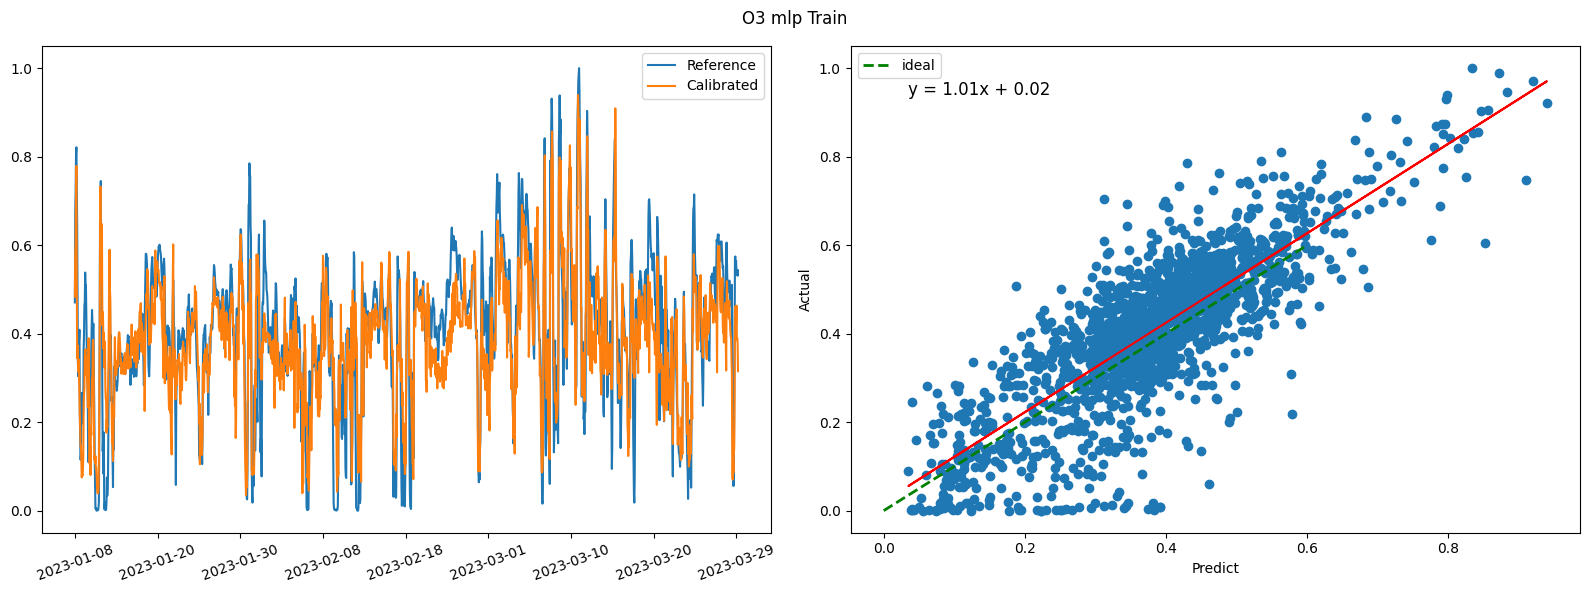

In [9]:
y_pred = model.predict(x_train)
visualize_result(y_train.ravel(), y_pred, train, f'{target_gas} {model_type} Train')
score(y_pred, y_train)

***R2 Score: 0.28
***RMSE: 0.1675


(0.28483547497892236, 0.16746969799884204)

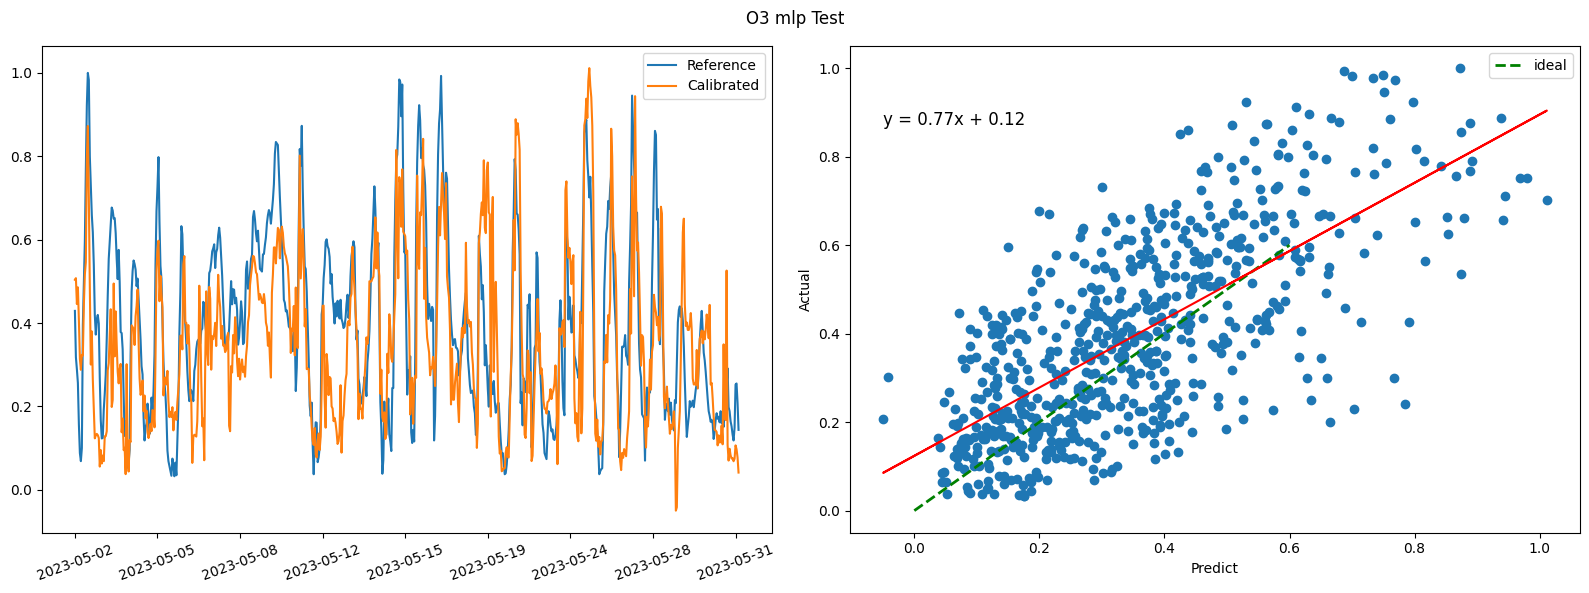

In [10]:
y_pred = model.predict(x_test)
visualize_result(y_test.ravel(), y_pred, test, f'{target_gas} {model_type} Test')
score(y_pred, y_test)